# 1. Introducción 

En una empresa emergente que se dedica a la venta de productos alimenticios, la investigación del comportamiento de los usuarios es crucial para optimizar el rendimiento y la satisfacción del cliente. Uno de los enfoques más eficaces para este propósito es el uso de pruebas A/A/B.

En este tipo de pruebas, los usuarios se dividen en tres grupos: dos grupos de control (A/A) y un grupo de prueba (B). Los dos grupos de control reciben una versión idéntica del producto o la interfaz, mientras que el grupo de prueba recibe una versión modificada. Este diseño es particularmente útil para asegurar que las pruebas sean precisas y libres de distorsiones.

Por ejemplo, si el equipo de diseño planea cambiar las fuentes de toda la aplicación, pero la gerencia teme que el nuevo diseño pueda ser intimidante para los usuarios, una prueba A/A/B permite medir el impacto de este cambio. Los grupos A actúan como referencia para validar la consistencia de los resultados. Si se detectan diferencias significativas entre los grupos A, esto indica posibles factores distorsionadores que deben ser investigados. Al mismo tiempo, la comparación entre los grupos de control y el grupo de prueba revela cuál conjunto de fuentes produce mejores resultados.

El uso de dos grupos de control proporciona confianza en la exactitud de nuestras pruebas y ayuda a determinar la cantidad de tiempo y datos necesarios para futuros experimentos. En resumen, las pruebas A/A/B no solo son esenciales para la toma de decisiones informadas, sino que también aseguran la integridad y validez de los resultados en una empresa dinámica y en constante crecimiento.



### 2. Abrir el archivo de datos y leer la información general

In [1]:
# Importacion de librerias
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from numpy import median
from pandas import pivot_table

In [ ]:
# Lectura de los dataframes
rest_data = pd.read_csv(
    "/datasets/logs_exp_us.csv")

#logs_exp_us = pd.read_csv(
#    "c:/Users/cary_/OneDrive/Escritorio/Data analyst/Sprint 11/logs_exp_us.csv", sep='\t')

### 3. Preparar los datos para el análisis

In [3]:
#Obtener informacion del dataset
logs_exp_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# Renombrar columnas
logs_exp_us = logs_exp_us.rename(columns={
                                 'EventName': 'event_name', 'DeviceIDHash': 'device_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

# Convertir a tipo datetime la columna event_timestamp
logs_exp_us['event_timestamp'] = pd.to_datetime(logs_exp_us['event_timestamp'], unit='s')

# Agregar columa solo de fecha
logs_exp_us['event_date'] = pd.to_datetime(logs_exp_us['event_timestamp'], format="%Y-%m-%d")


In [5]:
# Se crea una funcion para bajar los tipos de datos
def downcast_dtypes(df):
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns

    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast="integer")

    return df

# Usar la funcion en el dataframe
downcast_dtypes(logs_exp_us)

,event_name,device_id,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58


In [6]:
# Revisar si existe algún valor duplicado
print('Duplicados totales para logs_exp_us: ', logs_exp_us.duplicated().sum())

# Revisar si existe algún valor nulo
print('\nValores nulos totales para logs_exp_us: ', logs_exp_us.isnull().sum().sum())

# Eliminar valores duplicados
logs_exp_us = logs_exp_us.drop_duplicates()

Duplicados totales para logs_exp_us:  413

Valores nulos totales para logs_exp_us:  0


### 4. Estudiar y comprobar los datos

##### 4.1 ¿Cuántos eventos hay en los registros?

In [7]:
# Contar total de eventos en el dataframe
print('Número de eventos en el registro:', logs_exp_us['event_name'].nunique())

Número de eventos en el registro: 5


##### 4.2 ¿Cuántos usuarios y usuarias hay en los registros?

In [8]:
# Contar total de usuarios en el registro 
print('Total de usuarios y usuarias en el registro:', logs_exp_us['device_id'].nunique())

Total de usuarios y usuarias en el registro: 7551


##### 4.3 ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

Fecha mínima: 2019-08-01 00:07:28 Fecha máxima:  2019-08-07 21:15:17


(array([18109., 18110., 18111., 18112., 18113., 18114., 18115., 18116.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18110.0, 0, '2019-08-02'),
  Text(18111.0, 0, '2019-08-03'),
  Text(18112.0, 0, '2019-08-04'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18114.0, 0, '2019-08-06'),
  Text(18115.0, 0, '2019-08-07'),
  Text(18116.0, 0, '2019-08-08')])

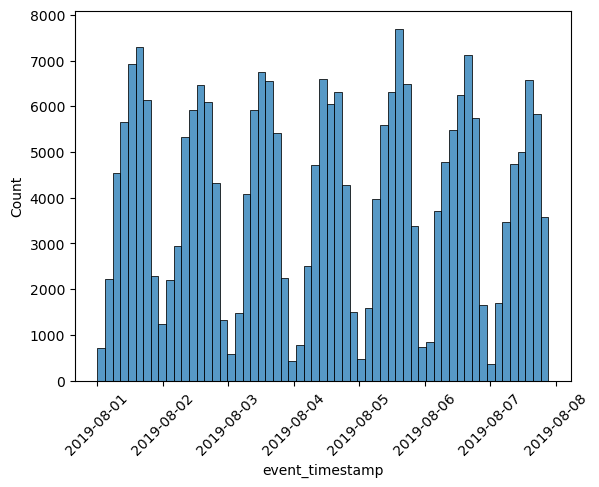

In [9]:
# Agrupar fechas para encontrar a partir de cuando estan completos lod datos
date_counts = logs_exp_us['event_timestamp'].groupby(logs_exp_us['event_timestamp'].dt.date).count()

# Filtar los datos a partir de que la informacion esta completa
date_filtered = logs_exp_us[logs_exp_us['event_timestamp'] >= '2019-08-01']

# Imprimir fecha máxima y mínima de las fechas filtradas
print(f'Fecha mínima:', date_filtered['event_timestamp'].min(), 'Fecha máxima: ', date_filtered['event_timestamp'].max()) 

# Crear histograma de la información filtrada
sns.histplot(data=date_filtered, x='event_timestamp', log_scale=True)

# Girar las etiquetas del eje x 45 grados
plt.xticks(rotation=45)

El histograma muestra la distribución de los datos por fecha, indicando la cantidad de eventos registrados cada día dentro del periodo cubierto.
Este análisis muestra que, aunque los datos iniciales abarcan una semana, es crucial identificar y trabajar solo con los periodos donde la recolección de datos fue consistente. Esto asegura la fiabilidad del análisis y evita sesgos debido a registros incompletos.

##### 4.4 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [10]:
# Numero de eventos dataset original 
num_events_original = logs_exp_us.shape[0]

# Numero de usuarios dataset original 
num_users_original = logs_exp_us['device_id'].nunique()

# Filtar los datos mas recientes
date_filtered = logs_exp_us[logs_exp_us['event_timestamp'] >= '2019-08-01']

# Numero de eventos dataset filtrado
num_events_filtered = date_filtered.shape[0]

# Numero de usuarios dataset filtrado
num_users_filtered = date_filtered['device_id'].nunique()

# Calular diferencia de eventos 
events_lost = num_events_original - num_events_filtered

# Calular diferencia de usuarios 
users_lost = num_users_original - num_users_filtered

# Impresion de resultados
print(f'Eventos originales: {num_events_original}, Usuarios originales: {num_users_original}')
print(f'Eventos filtrados: {num_events_filtered}, Usuarios filtrados: {num_users_filtered}')
print(f'Eventos perdidos: {events_lost}, Usuarios perdidos: {users_lost}')

Eventos originales: 243713, Usuarios originales: 7551
Eventos filtrados: 240887, Usuarios filtrados: 7534
Eventos perdidos: 2826, Usuarios perdidos: 17


El análisis inicial mostró un total de 243,713 eventos y 7,551 usuarios. Después de filtrar los datos inconsistentes o incompletos, los números se redujeron a 240,887 eventos y 7,534 usuarios. Se perdieron 2,826 eventos y 17 usuarios en el proceso de filtrado. Aunque parece una pérdida pequeña en términos absolutos, es importante asegurar que estos eventos y usuarios eliminados no afecten significativamente la integridad del análisis.La pérdida de eventos y usuarios puede indicar la necesidad de examinar la calidad y consistencia de los datos recogidos.

##### 4.5 Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

Text(0.5, 1.0, 'Número de usuarios por grupo')

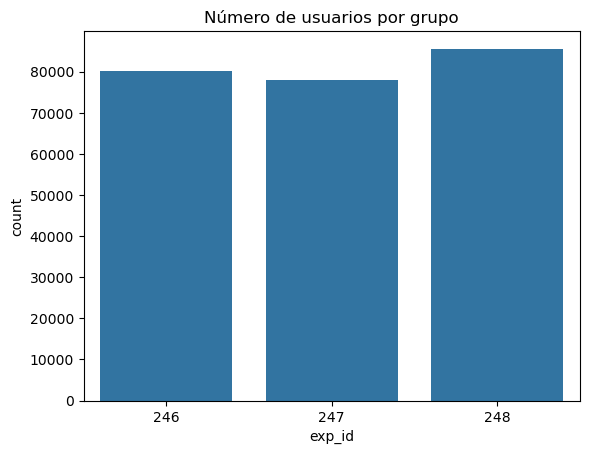

In [11]:
# Revisar la presencia de usuarios por grupo 
group_users = logs_exp_us['exp_id'].value_counts().reset_index()

# Se crea la grafica
ax = sns.barplot(x='exp_id', y='count', data=group_users)

# Se agrega un titulo
ax.set_title("Número de usuarios por grupo")


Se puede observar que el grupo 248 tiene la mayor cantidad de usuarios, seguido por el grupo 246 y finalmente el grupo 247. Aunque hay una diferencia en el número de usuarios entre los grupos, estas variaciones deben ser evaluadas para entender si pueden influir en los resultados del análisis.

### 5. Estudiar el embudo de eventos

##### 5.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'MainScreenAppear'),
  Text(1, 0, 'OffersScreenAppear'),
  Text(2, 0, 'CartScreenAppear'),
  Text(3, 0, 'PaymentScreenSuccessful'),
  Text(4, 0, 'Tutorial')])

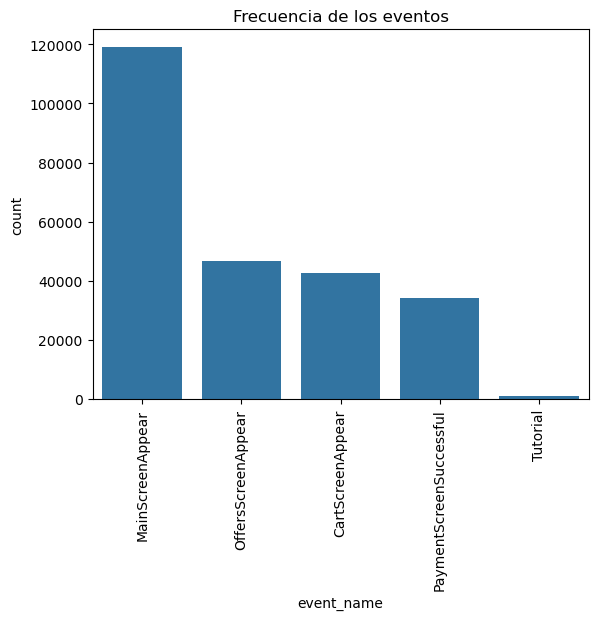

In [12]:
# Contar la fecuencia de los eventos
events_count = logs_exp_us['event_name'].value_counts().reset_index().sort_values(by='count', ascending=False)

# Se crea la grafica
ax = sns.barplot(x='event_name', y='count', data=events_count)

# Se agrega un titulo
ax.set_title("Frecuencia de los eventos")

# Se rotan las etiquetas del eje x
plt.xticks(rotation=90)

MainScreenAppear es el evento más frecuente, lo que indica que la mayoría de los usuarios interactúan con la pantalla principal de la aplicación. 

Ofertas y Carrito: Una parte significativa de los usuarios (4,613) explora las ofertas disponibles, pero este número disminuye cuando se trata de agregar productos al carrito (3,749). Esto sugiere un posible punto de mejora para convertir el interés en ofertas en acciones de compra.

Conversión a Pago: La transición desde el carrito hasta la compra exitosa se mantiene relativamente alta (3,547), lo que indica que una vez que los usuarios agregan productos al carrito, hay una buena tasa de conversión a compras efectivas.

Interacción con Tutoriales:El evento Tutorial tiene la menor cantidad de usuarios (847), lo que podría implicar que la aplicación es intuitiva para la mayoría o que los tutoriales no están siendo descubiertos/utilizados.

In [30]:
events_count

,event_name,device_id
0,MainScreenAppear,7439
1,OffersScreenAppear,4613
2,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


##### 5.2 Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

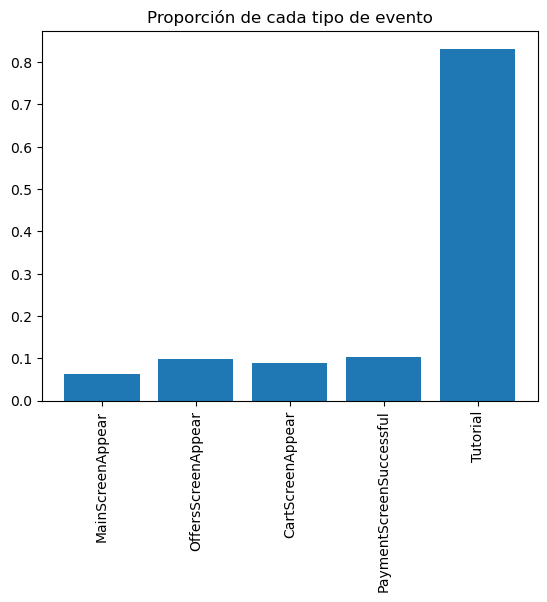

In [13]:
# Contar y ordenar la cantidad total de usuarios por cada evento
users_count_total = logs_exp_us.groupby('event_name')['device_id'].count().reset_index().sort_values(by='device_id', ascending=False)

# Contar y ordenar la cantidad de usuarios únicos por cada evento
users_count_unique = logs_exp_us.groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)

# Calculo de la proporcion de usuarios que realizaron la accion al menos una vez
proportion = users_count_unique['device_id'] / users_count_total['device_id']

# Se almancenan en variables los valores de las proporciones y los nombres de los eventos
keys = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
vals = proportion

# Se crea el grafico de barras de las proporciones de los eventos
plt.bar(keys, vals)

# Se agrega un titulo
plt.title('Proporción de cada tipo de evento')

# Se rotan las etiquetas del eje x
plt.xticks(rotation=90)

# Se muestra la garfica
plt.show()


In [ ]:
proportion
1    0.062460
2    0.098552
0    0.087864
3    0.103963
4    0.832024

1    0.062460
2    0.098552
0    0.087864
3    0.103963
4    0.832024
Name: device_id, dtype: float64

La mayoría de los usuarios (83.20%) interactúan con el evento Tutorial, lo que destaca su importancia en el flujo de la aplicación. Los eventos Offerscreen Cartscreeen y Paymentscreen tienen proporciones similares y moderadas, señalando que son parte del uso regular de la aplicación. El Mainscreen, con la menor proporción, sugiere una funcionalidad menos utilizada o una acción secundaria.

##### 5.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'MainScreenAppear'),
  Text(1, 0, 'OffersScreenAppear'),
  Text(2, 0, 'CartScreenAppear'),
  Text(3, 0, 'PaymentScreenSuccessful'),
  Text(4, 0, 'Tutorial')])

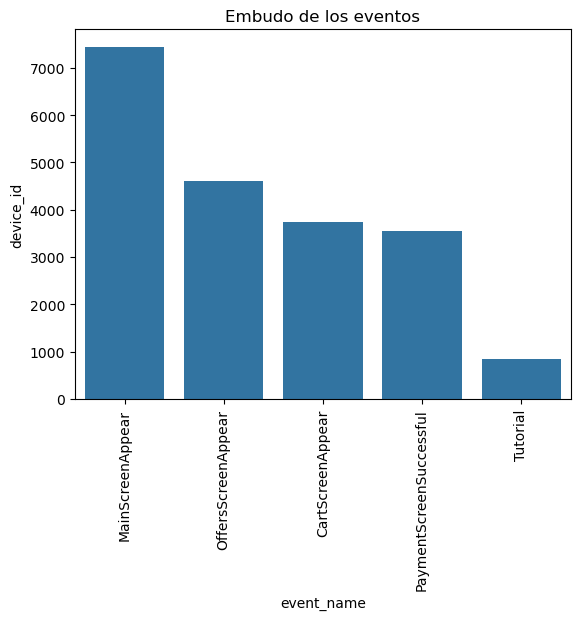

In [14]:
# Agrupar datos por cantidad de usuarios en cada evento 
events_count = logs_exp_us.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False).reset_index()

# Se crea la grafica
ax = sns.barplot(x='event_name', y='device_id', data=events_count)

# Se agrega un titulo
ax.set_title("Embudo de los eventos")

# Se rotan las etiquetas del eje x
plt.xticks(rotation=90)

In [32]:
events_count

,event_name,device_id
0,MainScreenAppear,7439
1,OffersScreenAppear,4613
2,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


El embudo de eventos muestra puntos clave donde los usuarios dejan el proceso: entre la pantalla principal y la exploración de ofertas, y luego al agregar productos al carrito. Mejora en estas etapas podría aumentar significativamente las conversiones. Además, fomentar el uso del tutorial podría mejorar la experiencia de usuario, especialmente para nuevos usuarios, haciendo que el flujo completo sea más fluido y eficiente.

##### 5.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [15]:
# Para cada usuario, busca la hora del primer suceso de cada evento
users = logs_exp_us.pivot_table(
    index='device_id', 
    columns='event_name', 
    values='event_timestamp',
    aggfunc='min')

# Número de filas en la tabla users para las cuales la columna MainScreenAppear contiene valores no vacíos.
step_1 = ~users['MainScreenAppear'].isna()

# Número de usuarios que accedieron al sitio y vieron las ofertas
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])

# Número de usuarios que accedieron al agregaron al carrito y vieron las ofertas
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])

# Número de usuarios que accedieron al agregaron al carrito y pagaron
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

# Número de usuarios que pagaron y vieron el tutorial
step_5 = step_4 & (users['Tutorial'] > users['PaymentScreenSuccessful'])

# Calulo del total de usuarios de cada evento 
n_main = users[step_1].shape[0]
n_offer = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]
n_tutorial = users[step_5].shape[0]

# Impresion de resultados de total de usuarios por evento
print('Visitantes:', n_main)
print('Ofertas:', n_offer)
print('Carrito:', n_cart)
print('Pagado:', n_payment)
print('Tutorial:', n_tutorial)

Visitantes: 7439
Ofertas: 4067
Carrito: 1611
Pagado: 448
Tutorial: 0


In [16]:
# Para cada usuario, busca la hora del primer suceso de cada evento
primeros_eventos_por_usuario = logs_exp_us.pivot_table(
    index='device_id', 
    columns='event_name', 
    values='event_timestamp', 
    aggfunc='min'
)

# Definir pasos
pasos = [
    ('MainScreenAppear', 'Vieron pantalla principal'),
    ('OffersScreenAppear', 'Vieron ofertas'),
    ('CartScreenAppear', 'Agregaron al carrito'),
    ('PaymentScreenSuccessful', 'Pagaron'),
    ('Tutorial', 'Vieron tutorial')
]


# Función para calcular número de usuarios en cada paso
def calcular_usuarios_en_paso(primeros_eventos, paso_actual, paso_anterior=None):
    if paso_anterior:
        return ~primeros_eventos[paso_actual].isna() & (primeros_eventos[paso_actual] > primeros_eventos[paso_anterior])
    else:
        return ~primeros_eventos[paso_actual].isna()

# Calcular número de usuarios en cada paso
num_usuarios_por_paso = []
proporciones = []
for i, (paso, descripcion, *paso_anterior) in enumerate(pasos):
    usuarios_en_paso = calcular_usuarios_en_paso(primeros_eventos_por_usuario, paso, *paso_anterior)
    num_usuarios_por_paso.append(usuarios_en_paso.sum())
    
    # Calcular proporción
    if i == 0:
        proporciones.append(usuarios_en_paso.sum() / primeros_eventos_por_usuario.shape[0])
    else:
        proporciones.append(usuarios_en_paso.sum() / num_usuarios_por_paso[i-1])

# Impresión de resultados
for i, (paso, descripcion) in enumerate(pasos):
    print(f'{descripcion}: {num_usuarios_por_paso[i]} usuarios ({proporciones[i]*100:.2f}% del total)')


Vieron pantalla principal: 7439 usuarios (98.52% del total)
Vieron ofertas: 4613 usuarios (62.01% del total)
Agregaron al carrito: 3749 usuarios (81.27% del total)
Pagaron: 3547 usuarios (94.61% del total)
Vieron tutorial: 847 usuarios (23.88% del total)


El embudo de eventos revela puntos críticos y oportunidades de mejora. La principal caída ocurre entre la pantalla principal y la visualización de ofertas, lo que sugiere que mejorar la navegación o la presentación de ofertas podría incrementar el número de usuarios que pasan a la siguiente fase del embudo. La alta tasa de conversión de carrito a pago es un punto fuerte, indicando que el proceso de compra es eficiente y efectivo. Mejorar la accesibilidad y visibilidad de los tutoriales podría beneficiar especialmente a los nuevos usuarios, proporcionando una mejor experiencia general.

##### 5.5 ¿En qué etapa pierdes más usuarios y usuarias?

In [17]:
# Calcular las pérdidas de una etapa a otra
perdidas = [num_usuarios_por_paso[i] - num_usuarios_por_paso[i + 1] for i in range(len(num_usuarios_por_paso) - 1)]

# Identificar la etapa con la mayor pérdida
mayor_perdida = max(perdidas)
etapa_mayor_perdida = perdidas.index(mayor_perdida)

# Imprimir los resultados
print(f'Perdida de A a B: {perdidas[0]} usuarios')
print(f'Perdida de B a C: {perdidas[1]} usuarios')
print(f'La mayor pérdida de usuarios ocurre entre la etapa {etapa_mayor_perdida + 1} y {etapa_mayor_perdida + 2}.')

Perdida de A a B: 2826 usuarios
Perdida de B a C: 864 usuarios
La mayor pérdida de usuarios ocurre entre la etapa 1 y 2.


Para mejorar la tasa de conversión general, es crucial enfocarse en la etapa entre A y B. Identificar y abordar las razones por las que los usuarios abandonan en esta fase puede ayudar a reducir la pérdida y aumentar el número de usuarios que avanzan a etapas posteriores. Las intervenciones podrían incluir mejoras en la experiencia de usuario, optimización del contenido o la interfaz, y resolución de posibles problemas técnicos.

##### 5.6 ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [18]:
# Número total de usuarios que empezaron el viaje
usuarios_inicio = num_usuarios_por_paso[0]

# Número de usuarios que completaron el viaje (llegaron a la etapa de pago)
usuarios_pago = num_usuarios_por_paso[-2]

# Calcular el porcentaje
porcentaje_completan_viaje = (usuarios_pago / usuarios_inicio) * 100

# Impresion de resultados
print(f'Porcentaje de usuarios que completan el viaje: {porcentaje_completan_viaje:.2f}%')

Porcentaje de usuarios que completan el viaje: 47.68%


Un 47.68% de finalización indica que hay un margen considerable para optimizar el recorrido del usuario. Mejorar la experiencia de usuario en etapas críticas del embudo podría incrementar significativamente la conversión. Identificar y abordar las barreras que impiden a los usuarios completar el viaje es crucial para mejorar la efectividad de la aplicación y aumentar la satisfacción del usuario.

### 6. Estudiar los resultados del experimento

##### 6.1 ¿Cuántos usuarios y usuarias hay en cada grupo?

Text(0.5, 1.0, 'Usuarios por grupo')

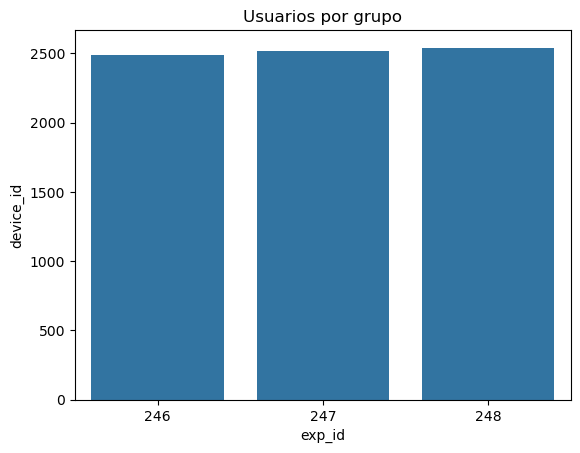

In [19]:
# Contar cuantos usuarios hay por grupo 
usuarios_por_grupo = logs_exp_us.groupby('exp_id')['device_id'].nunique().reset_index()

# Se crea la grafica
ax = sns.barplot(x='exp_id', y='device_id', data=usuarios_por_grupo)

# Se agrega un titulo
ax.set_title("Usuarios por grupo")


##### 6.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [20]:
# Filtrar los grupos de control 
grupo_246 = logs_exp_us[logs_exp_us['exp_id'] == 246]
grupo_247 = logs_exp_us[logs_exp_us['exp_id'] == 247]

# Agrupar por device_id y contar el numero de eventos para cada dispositivo en el grupo 246
eventos_246 = grupo_246.groupby('device_id')['event_name'].count()
# Agrupar por device_id y contar el numero de eventos para cada dispositivo en el grupo 247
eventos_247 = grupo_247.groupby('device_id')['event_name'].count()

# Realizar la prueba t de Student
t_stat, p_val = stats.ttest_ind(eventos_246, eventos_247)

# Evaluar el resultado
alpha = 0.05  # Nivel de significancia
if p_val < alpha:
    print('Hay una diferencia estadísticamente significativa entre las muestras 246 y 247.')
else:
    print('No hay una diferencia estadísticamente significativa entre las muestras 246 y 247.')

No hay una diferencia estadísticamente significativa entre las muestras 246 y 247.


##### 6.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [21]:
# Creacion de funcion para encontrar el evento mas popular, encontrar la proporcion y la direncia estadistica
def analizar_eventos(df):
    resultados = []
    for evento in df['event_name'].unique():# Encontrar el evento más popular
        event_data = df[df['event_name'] == evento] # Filtrado de eventos
        usuarios_246 = event_data[event_data['exp_id'] == 246]['device_id'].nunique()# Calcular la cantidad de usuarios en cada grupo que realizaron el evento
        usuarios_247 = event_data[event_data['exp_id'] == 247]['device_id'].nunique()
        total_246 = df[df['exp_id'] == 246]['device_id'].nunique()# Calcular el total de usuarios en cada grupo
        total_247 = df[df['exp_id'] == 247]['device_id'].nunique()

        # Calcular la proporción
        proporcion_246 = usuarios_246 / total_246
        proporcion_247 = usuarios_247 / total_247
        
        # Encontrar la diferncia estadistica entre ambos grupos
        t_stat, p_val = stats.ttest_ind(
            event_data[event_data['exp_id'] == 246]['device_id'],
            event_data[event_data['exp_id'] == 247]['device_id']
        )

        # Guardar los resultados
        resultados.append({
            'evento': evento,
            'proporcion_246': proporcion_246,
            'proporcion_247': proporcion_247,
            'p_val': p_val
        })
    
    return pd.DataFrame(resultados)

# Analizar todos los eventos
resultados_eventos = analizar_eventos(logs_exp_us)

# Impresion de resultados
print(resultados_eventos)


                    evento  proporcion_246  proporcion_247         p_val
0         MainScreenAppear        0.986742        0.984921  2.842443e-05
1  PaymentScreenSuccessful        0.482925        0.460317  6.208295e-03
2         CartScreenAppear        0.510245        0.492063  4.096085e-05
3       OffersScreenAppear        0.620731        0.607143  1.102540e-20
4                 Tutorial        0.112093        0.113492  9.056465e-01


 Las diferencias significativas en eventos clave como la pantalla principal, el carrito y las compras exitosas indican que, aunque los grupos de control tienen proporciones similares en términos generales, existen variaciones notables en ciertos puntos del flujo de usuario. Este análisis resalta la importancia de revisar y entender las diferencias entre grupos, incluso en pruebas A/A, para asegurar la exactitud y la validez de las pruebas A/B futuras.

##### 6.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [33]:
# Crear la tabla pivote
eventos = logs_exp_us.pivot_table(index='event_name', values='device_id', columns='exp_id', aggfunc='nunique')

# Diccionario para guadar los resultados
resultados = []

for evento in eventos.index:
    # Obtenemos los datos de cada grupo (deben ser arrays de valores)
    count_246 = logs_exp_us[(logs_exp_us['exp_id'] == 246) & (logs_exp_us['event_name'] == evento)]['device_id']
    count_247 = logs_exp_us[(logs_exp_us['exp_id'] == 247) & (logs_exp_us['event_name'] == evento)]['device_id']
    count_248 = logs_exp_us[(logs_exp_us['exp_id'] == 248) & (logs_exp_us['event_name'] == evento)]['device_id']
    
    # Verificar si tenemos múltiples valores para cada grupo
    if len(count_246) > 1 and len(count_247) > 1 and len(count_248) > 1:
        # Realizar ANOVA para los tres grupos
        f_stat, p_val = stats.f_oneway(count_246, count_247, count_248)
    else:
        f_stat, p_val = (None, None)  # No se puede realizar ANOVA con un solo valor por grupo
    
    resultados.append({
        'evento': evento,
        'count_246': len(count_246),
        'count_247': len(count_247),
        'count_248': len(count_248),
        'p_val': p_val
    })

# Crear un DataFrame con los resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

                    evento  count_246  count_247  count_248         p_val
0         CartScreenAppear      14798      12548      15322  3.073662e-09
1         MainScreenAppear      38249      39677      41175  4.105906e-08
2       OffersScreenAppear      14904      15341      16563  3.104986e-27
3  PaymentScreenSuccessful      11912      10039      12167  1.681890e-07
4                 Tutorial        318        345        355  7.872008e-01


El grupo 248 muestra consistentemente el mayor número de usuarios en casi todas las etapas clave del embudo, indicando que el diseño o las fuentes nuevas podrían estar teniendo un impacto positivo. Sin embargo, es importante notar que el evento del tutorial no muestra diferencias significativas, lo que sugiere una experiencia de usuario consistente en ese aspecto específico.

##### 6.5 Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

In [34]:
def analizar_eventos_completo(df, eventos, grupos_control, nivel_significancia):
    resultados = []
    for evento in eventos.index:
        # Obtener datos para cada grupo
        grupo_246 = df[(df['event_name'] == evento) & (df['exp_id'] == 246)]['device_id']
        grupo_247 = df[(df['event_name'] == evento) & (df['exp_id'] == 247)]['device_id']
        grupo_248 = df[(df['event_name'] == evento) & (df['exp_id'] == 248)]['device_id']
        
        if len(grupo_246) > 1 and len(grupo_247) > 1 and len(grupo_248) > 1:
            # Realizar ANOVA para los tres grupos con arrays de valores
            f_stat, p_val = stats.f_oneway(grupo_246, grupo_247, grupo_248)
        else:
            f_stat, p_val = (None, None)  # No se puede realizar ANOVA con arrays de un solo valor
        
        resultados.append({
            'evento': evento,
            'count_246': len(grupo_246),
            'count_247': len(grupo_247),
            'count_248': len(grupo_248),
            'p_val': p_val
        })
    
    return pd.DataFrame(resultados)

# Establecer el nivel de significancia original y ajustado
nivel_significancia_original = 0.1
num_pruebas = len(eventos.index)
nivel_significancia_ajustado = nivel_significancia_original / num_pruebas
print(f'Nivel de significancia ajustado: {nivel_significancia_ajustado}')

# Analizar todos los eventos con el nivel de significancia ajustado
resultados_eventos = analizar_eventos_completo(logs_exp_us, eventos, [246, 247, 248], nivel_significancia_ajustado)
print(resultados_eventos)

Nivel de significancia ajustado: 0.02
                    evento  count_246  count_247  count_248         p_val
0         CartScreenAppear      14798      12548      15322  3.073662e-09
1         MainScreenAppear      38249      39677      41175  4.105906e-08
2       OffersScreenAppear      14904      15341      16563  3.104986e-27
3  PaymentScreenSuccessful      11912      10039      12167  1.681890e-07
4                 Tutorial        318        345        355  7.872008e-01


Incluso con un nivel de significancia ajustado a 0.02, los eventos clave como agregar al carrito, ver la pantalla principal, ofertas y pagos exitosos muestran diferencias significativas entre los tres grupos, especialmente para el grupo 248, que consistentemente tiene más usuarios participando en estos eventos. Esto sugiere que las fuentes nuevas podrían estar teniendo un impacto positivo en la interacción del usuario. El evento tutorial sigue sin mostrar diferencias significativas, lo que indica consistencia en esa área.

# 7. Conclusión 

Periodo de datos y consistencia:

Fechas: Los datos cubren desde el 1 de agosto de 2019 hasta el 7 de agosto de 2019. Tras analizar los eventos, se identificó que algunos datos más antiguos podrían no estar completos, lo que podría sesgar el análisis. Es crucial trabajar con los periodos donde la recolección de datos fue consistente.

Eventos y usuarios:

Eventos originales y filtrados: De 243,713 eventos y 7,551 usuarios originales, los datos filtrados muestran 240,887 eventos y 7,534 usuarios. Se perdieron 2,826 eventos y 17 usuarios, lo que subraya la importancia de revisar la integridad de los datos restantes.

Distribución de usuarios por grupo (exp_id):

Usuarios por grupo: Grupo 248 tiene 85,582 usuarios, grupo 246 tiene 80,181, y grupo 247 tiene 77,950. Aunque los tamaños de los grupos varían, estas diferencias deben ser consideradas en el análisis.

Embudo de eventos:

Eventos principales: MainScreenAppear es el evento más frecuente (7,439 usuarios), seguido por OffersScreenAppear, CartScreenAppear, y PaymentScreenSuccessful. La mayor caída se observa entre la pantalla principal y la exploración de ofertas.

Proporciones: El evento MainScreenAppear tiene la mayor proporción de interacción, seguido por otros eventos clave, y el tutorial tiene la menor proporción.

Pérdidas de usuarios en el embudo:

La mayor pérdida de usuarios ocurre entre la etapa 1 (A) y la etapa 2 (B) con 2,826 usuarios, mientras que la pérdida de B a C es menor (864 usuarios). Esto indica la necesidad de optimizar la etapa crítica entre A y B.

Porcentaje de usuarios que completan el viaje:

Tasa de finalización: 47.68% de los usuarios completan el viaje completo desde el primer evento hasta el pago. Esto sugiere un margen considerable para mejorar la tasa de conversión.

Análisis de pruebas A/A/B:

**Eventos como MainScreenAppear, CartScreenAppear, PaymentScreenSuccessful y OffersScreenAppear muestran diferencias significativas en las proporciones de usuarios entre los grupos. El grupo 248 consistentemente muestra una mayor interacción en estos eventos.

Nivel de significancia ajustado: Con un nivel ajustado de 0.02, las diferencias en eventos clave siguen siendo estadísticamente significativas, reforzando la validez de las observaciones.

El análisis detallado revela puntos clave donde la optimización puede mejorar significativamente la experiencia y conversión del usuario. Las diferencias entre los grupos de control y el grupo de prueba indican que el nuevo diseño (grupo 248) podría tener un impacto positivo en la interacción del usuario. Además, asegurar la integridad de los datos y optimizar las etapas críticas del embudo es esencial para mejorar los resultados generales